In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qibo.symbols import *
from qibo import hamiltonians
from functions import *
from tqdm import tqdm

In [55]:
def DBQITE_thirdOrderYudai(iters, H, step, state, trotterization = 1):
    """
    DBQITE 3rd order algorithm.
    """
    phi = (np.sqrt(5)+1)/2
    newState = np.empty((iters+1,len(state)), dtype=complex)
    newState[0,:] = state
    for i in range(iters):
        rho = np.outer(newState[i,:], newState[i,:].conj())
        t = np.sqrt(step)
        E1 = sp.linalg.expm(1j*t*np.sqrt(phi)*H)
        E2 = sp.linalg.expm(1j*t/np.sqrt(phi)*H)
        E3 = sp.linalg.expm(-1j*t*(1+phi)/np.sqrt(phi)*H)
        ref1 = sp.linalg.expm(1j*t*(1+phi)/np.sqrt(phi)*rho)
        ref2 = sp.linalg.expm(-1j*t/np.sqrt(phi)*rho)
        U = E1@ref1@E2@ref2@E3
        newState[i+1,:] = U@newState[i,:]
        newState[i+1,:] = newState[i+1,:]/np.sqrt(np.conj(newState[i+1,:])@newState[i+1,:])
    return newState

In [3]:
def thermalState(hamiltonian, beta):
    rho = sp.linalg.expm(-beta * hamiltonian)
    rho /= np.trace(rho)
    return rho

def optimalFidelityStepRho(H, beta, betaPrime):
    rhoBeta = thermalState(H, beta)
    betaMid = (beta + betaPrime)/2
    rhoBetaMid = thermalState(H, betaMid)
    energyBeta = np.real(np.trace(rhoBeta @ H))
    energyBetaMid = np.real(np.trace(rhoBetaMid @ H))
    V = np.real(np.trace(rhoBeta @ H @ H)) - energyBeta**2
    phi = np.arctan((energyBeta-energyBetaMid)/np.sqrt(V))
    sOpt = phi/(np.sqrt(V))
    return sOpt

def partial_trace(rho, nqubits, keep=0):

    d = 2 ** (nqubits // 2)  # Dimension of each subsystem
    rho = rho.reshape([d, d, d, d])  # Reshape into a 4D tensor

    if keep == 0:  # Trace out the second subsystem (B)
        return np.trace(rho, axis1=1, axis2=3)  # Partial trace over B
    else:  # Trace out the first subsystem (A)
        return np.trace(rho, axis1=0, axis2=2)  # Partial trace over A


[Qibo 0.2.16|WARNING|2025-05-22 11:33:19]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 300/300 [01:59<00:00,  2.52it/s]


Text(0.5, 1.0, 'Fidelity between DBI and DBQITE_thirdorder')

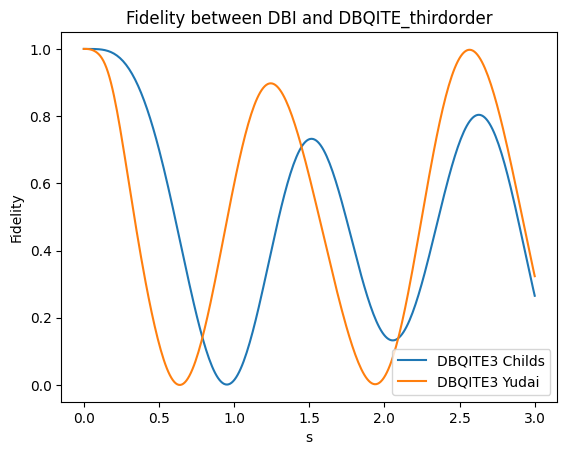

In [66]:
nqubits = 4
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H1)
H = np.kron(H1, np.eye(2**nqubits))
energies = np.linalg.eigvalsh(H)
eigenvectors = np.eye(2**nqubits)
initState = maxEntangledState(nqubits,eigenvectors)
s = np.linspace(0, 3, 300)
fidelity = np.zeros(len(s))
fidelity2 = np.zeros(len(s))

sEnergy = optimalEnergyStep(H, initState)
sThermal = optimalFidelityStepRho(H, 0, 0.01)
sThermal2 = optimalFidelityStepRho(H, 0, 0.1)
sThermal3 = optimalFidelityStepRho(H, 0, 1)

for i in tqdm(range(len(s))):
    stateDBI = DBI(1, H, s[i], initState)[-1,:]
    stateDBQITE3 = DBQITE_thirdOrder(1, H, s[i], initState)[-1,:]
    fidelity[i] = Fidelity(stateDBI, stateDBQITE3)
    stateDBQITE3Yudai = DBQITE_thirdOrderYudai(1, H, s[i], initState)[-1,:]
    fidelity2[i] = Fidelity(stateDBI, stateDBQITE3Yudai)

plt.plot(s, fidelity, label="DBQITE3 Childs")
plt.plot(s, fidelity2, label="DBQITE3 Yudai")
# plt.axvline(x=sEnergy, color='r', linestyle='--', label="Optimal Energy Step")
# plt.axvline(x=sThermal, color='g', linestyle='--', label=r"Optimal Thermal Step ($\beta=0.01$)")
# plt.axvline(x=sThermal2, color='b', linestyle='--', label=r"Optimal Thermal Step ($\beta=0.1$)")
# plt.axvline(x=sThermal3, color='y', linestyle='--', label=r"Optimal Thermal Step ($\beta=1$)")
plt.legend()
plt.xlabel("s")
plt.ylabel("Fidelity")
plt.title("Fidelity between DBI and DBQITE_thirdorder")

[Qibo 0.2.16|WARNING|2025-06-04 10:33:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 30/30 [04:08<00:00,  8.27s/it]


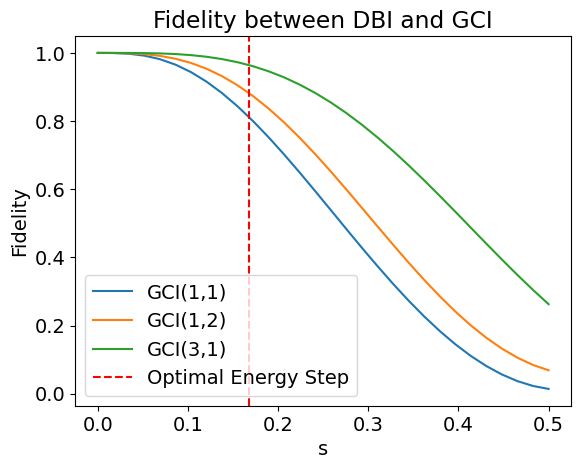

In [12]:
nqubits = 10
plt.rcParams.update({'font.size': 14})

H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
initState = np.zeros(2**nqubits, dtype=complex)
initState[0] = 1.0
s = np.linspace(0, 0.5, 30)

FidelityGCI11 = np.zeros(len(s))
FidelityGCI12 = np.zeros(len(s))
FidelityGCI31 = np.zeros(len(s))

sOptim = optimalEnergyStep(H, initState)
for i in tqdm(range(len(s))):
    stateDBI = DBI(1, H, s[i], initState)[-1,:]
    stateGCI11 = DBQITE(1, H, s[i], initState, trotterization=1)[-1,:]
    stateGCI12 = DBQITE(1, H, s[i], initState, trotterization=2)[-1,:]
    stateGCI31 = DBQITE_thirdOrder(1, H, s[i], initState)[-1,:]
    FidelityGCI11[i] = Fidelity(stateDBI, stateGCI11)
    FidelityGCI12[i] = Fidelity(stateDBI, stateGCI12)
    FidelityGCI31[i] = Fidelity(stateDBI, stateGCI31)

plt.figure()
plt.plot(s, FidelityGCI11, label="GCI(1,1)")
plt.plot(s, FidelityGCI12, label="GCI(1,2)")
plt.plot(s, FidelityGCI31, label="GCI(3,1)")
plt.axvline(x=sOptim, color='r', linestyle='--', label="Optimal Energy Step")
plt.xlabel("s")
plt.ylabel("Fidelity")
plt.title("Fidelity between DBI and GCI")
plt.legend()
plt.show()

[Qibo 0.2.16|WARNING|2025-06-04 10:30:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 30/30 [03:15<00:00,  6.53s/it]


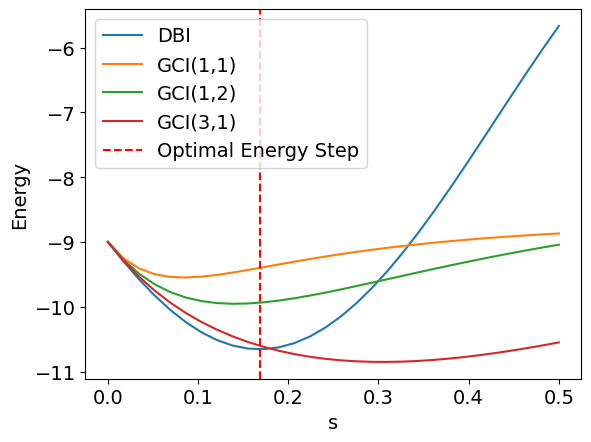

In [11]:
nqubits = 10
plt.rcParams.update({'font.size': 14})

H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
initState = np.zeros(2**nqubits, dtype=complex)
initState[0] = 1.0
s = np.linspace(0, 0.5, 30)

EnergyDBI = np.zeros(len(s))
EnergyGCI11 = np.zeros(len(s))
EnergyGCI12 = np.zeros(len(s))
EnergyGCI31 = np.zeros(len(s))

sOptim = optimalEnergyStep(H, initState)
for i in tqdm(range(len(s))):
    stateDBI = DBI(1, H, s[i], initState)[-1,:]
    stateGCI11 = DBQITE(1, H, s[i], initState, trotterization=1)[-1,:]
    stateGCI12 = DBQITE(1, H, s[i], initState, trotterization=2)[-1,:]
    stateGCI31 = DBQITE_thirdOrder(1, H, s[i], initState)[-1,:]
    EnergyDBI[i] = np.real(np.vdot(stateDBI, H @ stateDBI))
    EnergyGCI11[i] = np.real(np.vdot(stateGCI11, H @ stateGCI11))
    EnergyGCI12[i] = np.real(np.vdot(stateGCI12, H @ stateGCI12))
    EnergyGCI31[i] = np.real(np.vdot(stateGCI31, H @ stateGCI31))

plt.figure()
plt.plot(s, EnergyDBI, label="DBI")
plt.plot(s, EnergyGCI11, label="GCI(1,1)")
plt.plot(s, EnergyGCI12, label="GCI(1,2)")
plt.plot(s, EnergyGCI31, label="GCI(3,1)")
plt.axvline(x=sOptim, color='r', linestyle='--', label="Optimal Energy Step")
plt.xlabel("s")
plt.ylabel("Energy")
plt.legend()
plt.show()

[Qibo 0.2.16|WARNING|2025-06-03 14:31:32]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


Text(0, 0.5, 'Fidelity')

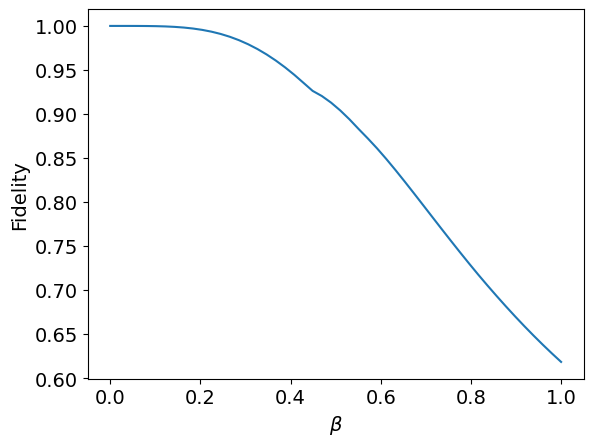

In [8]:
nqubits = 5
plt.rcParams.update({'font.size': 14})

H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H1)
H = np.kron(H1, np.eye(2**nqubits))
energies = np.linalg.eigvalsh(H)
eigenvectors = np.eye(2**nqubits)
initState = maxEntangledState(nqubits,eigenvectors)
beta = np.linspace(0, 1, 50)
fidelityDBI = np.zeros(len(beta))
fidelityDBQITE = np.zeros(len(beta))
fidelityDBQITE_trotter2 = np.zeros(len(beta))
fidelityDBQITE_trotter3 = np.zeros(len(beta))
fidelityDBQITE3 = np.zeros(len(beta))


for i in tqdm(range(len(beta))):
    rhoTarget = thermalState(H1, beta[i])
    sOptim = optimalFidelityStepRho(H1, 0, beta[i])
    stateDBI = DBI(1, H, sOptim, initState)[-1,:]
    rhoDBI = np.outer(stateDBI, stateDBI.conj())
    rhoA = partial_trace(rhoDBI, 2*nqubits, keep=0)
    fidelityDBI[i] = UJFidelity(rhoA, rhoTarget)
    # stateDBQITE = DBQITE(1, H, sOptim, initState, 1)[-1,:]
    # rhoDBQITE = np.outer(stateDBQITE, stateDBQITE.conj())
    # rhoA = partial_trace(rhoDBQITE, 2*nqubits, keep=0)
    # fidelityDBQITE[i] = UJFidelity(rhoA, rhoTarget)
    # stateDBQITE3 = DBQITE_thirdOrder(1, H, sOptim, initState)[-1,:]
    # rhoDBQITE3 = np.outer(stateDBQITE3, stateDBQITE3.conj())
    # rhoA = partial_trace(rhoDBQITE3, 2*nqubits, keep=0)
    # fidelityDBQITE3[i] = UJFidelity(rhoA, rhoTarget)
    # stateDBQITE_trotter2 = DBQITE(1, H, sOptim, initState, 2)[-1,:]
    # rhoDBQITE_trotter2 = np.outer(stateDBQITE_trotter2, stateDBQITE_trotter2.conj())
    # rhoA = partial_trace(rhoDBQITE_trotter2, 2*nqubits, keep=0)
    # fidelityDBQITE_trotter2[i] = UJFidelity(rhoA, rhoTarget)
    # stateDBQITE_trotter3 = DBQITE(1, H, sOptim, initState, 3)[-1,:]
    # rhoDBQITE_trotter3 = np.outer(stateDBQITE_trotter3, stateDBQITE_trotter3.conj())
    # rhoA = partial_trace(rhoDBQITE_trotter3, 2*nqubits, keep=0)
    # fidelityDBQITE_trotter3[i] = UJFidelity(rhoA, rhoTarget)



plt.figure()
plt.plot(beta, fidelityDBI)
# plt.plot(beta, fidelityDBQITE, label="DBQITE")
# plt.plot(beta, fidelityDBQITE3, label="DBQITE 3rd Order")
# plt.plot(beta, fidelityDBQITE_trotter2, label="DBQITE Trotter 2nd Order")
# plt.plot(beta, fidelityDBQITE_trotter3, label="DBQITE Trotter 3rd Order")

plt.xlabel(r"$\beta$")
plt.ylabel("Fidelity")

[Qibo 0.2.16|WARNING|2025-05-22 11:26:27]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 100/100 [00:01<00:00, 90.38it/s]


Text(0.5, 1.0, 'Fidelity using optimal Thermal Fidelity Step')

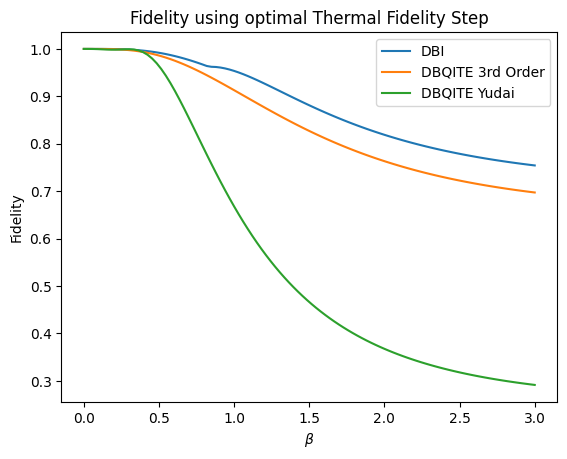

In [52]:
nqubits = 3
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H1)
H = np.kron(H1, np.eye(2**nqubits))
energies = np.linalg.eigvalsh(H)
eigenvectors = np.eye(2**nqubits)
initState = maxEntangledState(nqubits,eigenvectors)
beta = np.linspace(0, 3, 100)
fidelityDBI = np.zeros(len(beta))
fidelityDBQITE3 = np.zeros(len(beta))
fidelityDBQITEYudai = np.zeros(len(beta))


for i in tqdm(range(len(beta))):
    rhoTarget = thermalState(H1, beta[i])
    sOptim = optimalFidelityStepRho(H1, 0, beta[i])
    stateDBI = DBI(1, H, sOptim, initState)[-1,:]
    rhoDBI = np.outer(stateDBI, stateDBI.conj())
    rhoA = partial_trace(rhoDBI, 2*nqubits, keep=0)
    fidelityDBI[i] = UJFidelity(rhoA, rhoTarget)
    stateDBQITE3 = DBQITE_thirdOrder(1, H, sOptim, initState)[-1,:]
    rhoDBQITE3 = np.outer(stateDBQITE3, stateDBQITE3.conj())
    rhoA = partial_trace(rhoDBQITE3, 2*nqubits, keep=0)
    fidelityDBQITE3[i] = UJFidelity(rhoA, rhoTarget)
    stateDBQITEYudai = DBQITE_thirdOrderYudai(1, H, sOptim, initState)[-1,:]
    rhoDBQITEYudai = np.outer(stateDBQITEYudai, stateDBQITEYudai.conj())
    rhoA = partial_trace(rhoDBQITEYudai, 2*nqubits, keep=0)
    fidelityDBQITEYudai[i] = UJFidelity(rhoA, rhoTarget)




plt.figure()
plt.plot(beta, fidelityDBI, label="DBI")
plt.plot(beta, fidelityDBQITE3, label="DBQITE 3rd Order")
plt.plot(beta, fidelityDBQITEYudai, label="DBQITE Yudai")

plt.legend()
plt.xlabel(r"$\beta$")
plt.ylabel("Fidelity")
plt.title("Fidelity using optimal Thermal Fidelity Step")

[Qibo 0.2.16|WARNING|2025-05-21 14:34:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 100/100 [09:08<00:00,  5.49s/it]


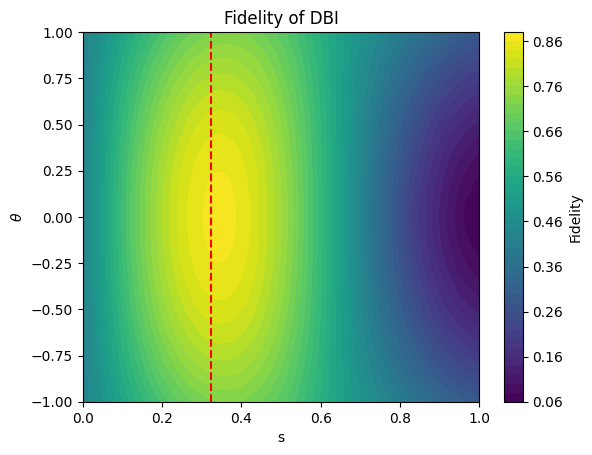

In [72]:
nqubits = 4
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvectors = np.eye(2**nqubits)
initState = maxEntangledState(nqubits,eigenvectors)
H = np.kron(H1, np.eye(2**nqubits))
s = np.linspace(0, 1, 100)
theta = np.linspace(-1, 1, 100)
rhoTarget = thermalState(H1, 1.0)
fidelity = np.zeros((len(s), len(theta)))
fidelitywoTheta = np.zeros(len(s))
sOptim = optimalFidelityStepRho(H1, 0, 1.0)
for i in tqdm(range(len(s))):
    for j in range(len(theta)):
        stateDBI = DBIComplex(initState, H, s[i], theta[j])
        rho = np.outer(stateDBI, stateDBI.conj())
        rhoA = partial_trace(rho, 2*nqubits, keep=0)
        fidelity[i,j] = UJFidelity(rhoA, rhoTarget)

plt.figure()
plt.contourf(s, theta,fidelity.T, levels= 50)
plt.colorbar(label="Fidelity")
plt.xlabel("s")
plt.axvline(x=sOptim, color='r', linestyle='--')
plt.ylabel(r"$\theta$")
plt.title("Fidelity of DBI")
plt.show()


[Qibo 0.2.16|WARNING|2025-05-21 14:43:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 100/100 [00:04<00:00, 22.38it/s]


Text(0, 0.5, 'Fidelity')

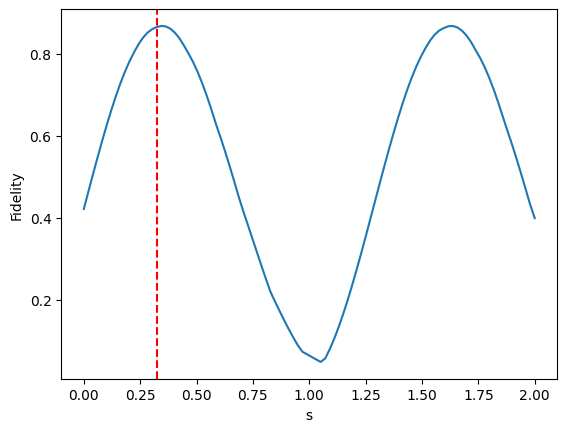

In [73]:
nqubits = 4
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvectors = np.eye(2**nqubits)
initState = maxEntangledState(nqubits,eigenvectors)
H = np.kron(H1, np.eye(2**nqubits))
s = np.linspace(0, 2.0, 100)
theta = np.linspace(-1, 1, 100)
rhoTarget = thermalState(H1, 1.0)
fidelity = np.zeros((len(s)))
fidelitywoTheta = np.zeros(len(s))
sOptim = optimalFidelityStepRho(H1, 0, 1.0)
for i in tqdm(range(len(s))):
    stateDBI = DBI(1, H, s[i], initState)[-1,:]
    rho = np.outer(stateDBI, stateDBI.conj())
    rhoA = partial_trace(rho, 2*nqubits, keep=0)
    fidelity[i] = UJFidelity(rhoA, rhoTarget)

plt.figure()
plt.plot(s, fidelity)
plt.axvline(x=sOptim, color='r', linestyle='--')
plt.xlabel("s")
plt.ylabel("Fidelity")  
